In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from collections import Counter
from tqdm import tqdm

In [2]:
for root, dirs, files in os.walk('/kaggle/input/mri-breast-cancer-detection/MRI_Data/MRI'):
    print(f"📂 Folder: {root}")
    print(f"   📁 Subfolders: {dirs}")
    print(f"   📄 Files: {files[:5]}")  # Print only first 5 files per folder
    print("-" * 40)

📂 Folder: /kaggle/input/mri-breast-cancer-detection/MRI_Data/MRI
   📁 Subfolders: ['normal', 'carcinoma']
   📄 Files: []
----------------------------------------
📂 Folder: /kaggle/input/mri-breast-cancer-detection/MRI_Data/MRI/normal
   📁 Subfolders: []
   📄 Files: ['1269.jpg', '623.jpg', '764.jpg', '1075.jpg', '771.jpg']
----------------------------------------
📂 Folder: /kaggle/input/mri-breast-cancer-detection/MRI_Data/MRI/carcinoma
   📁 Subfolders: []
   📄 Files: ['1269.jpg', '266.jpeg', '14.jpeg', '564.jpeg', '55.jpeg']
----------------------------------------


In [3]:
# Define your two label categories
class_map = {
    "normal": 0,
    "carcinoma": 1,
}

base_path = Path('/kaggle/input/mri-breast-cancer-detection/MRI_Data/MRI')



In [12]:
def get_image_paths(base_path, class_map):
    paths = []
    for folder in base_path.iterdir():
        if folder.is_dir() and folder.name in class_map:
            label = class_map[folder.name]
            for img_path in folder.glob('*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    paths.append((str(img_path), label))
    return paths

def is_image_valid(path):
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        return img is not None and img.size > 0
    except:
        return False

def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def visualize_samples(X, y, n=5):
    plt.figure(figsize=(15, 3))
    random_indices = np.random.choice(len(X), size=n, replace=False)
    
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i+1)
        plt.imshow(X[idx], cmap='gray')
        plt.title("carcinoma" if y[idx] == 1 else "Normal")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def check_dimensions(X):
    return Counter([img.shape for img in X])

def plot_intensity_histogram(X):
    all_pixels = np.concatenate([img.flatten() for img in X])
    plt.hist(all_pixels, bins=50, color='gray')
    plt.title('Pixel Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [5]:
# Load and validate data
labeled_paths = get_image_paths(base_path, class_map)
valid_labeled_paths = list(filter(lambda x: is_image_valid(x[0]), tqdm(labeled_paths, desc="Checking for corrupted files")))


Checking for corrupted files: 100%|██████████| 2807/2807 [00:22<00:00, 126.64it/s]


In [7]:
image_paths, labels = zip(*valid_labeled_paths)
X = list(map(load_image, tqdm(image_paths, desc="Loading images")))
y = list(labels)

# print(y)

Loading images: 100%|██████████| 2807/2807 [00:11<00:00, 236.53it/s]


In [8]:
class_counts = Counter(y)
print("Class distribution:", class_counts)

Class distribution: Counter({1: 1482, 0: 1325})


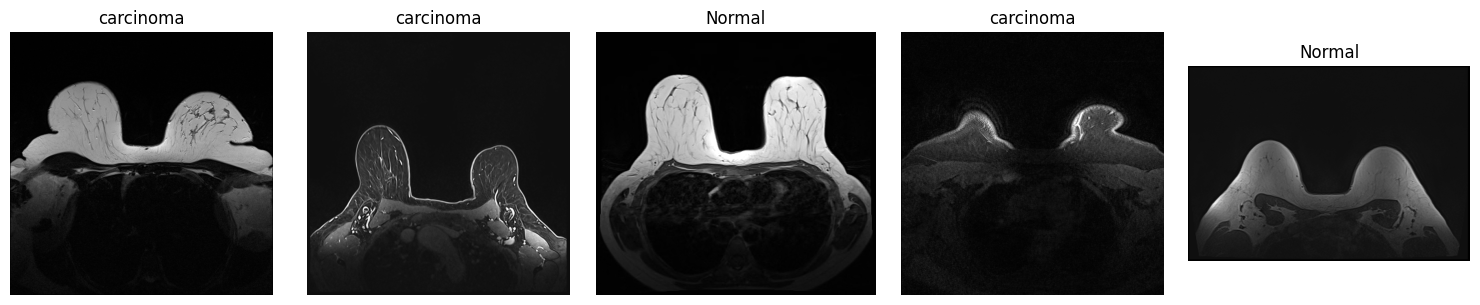

In [14]:
visualize_samples(X, y)

In [15]:
dims = check_dimensions(X)
print("Image dimension consistency:", dims)

Image dimension consistency: Counter({(512, 512): 521, (640, 640): 505, (457, 657): 286, (451, 665): 244, (476, 630): 243, (455, 658): 225, (630, 630): 209, (630, 566): 140, (320, 340): 120, (320, 320): 98, (320, 350): 60, (384, 408): 47, (704, 704): 40, (528, 528): 40, (256, 256): 20, (384, 384): 9})


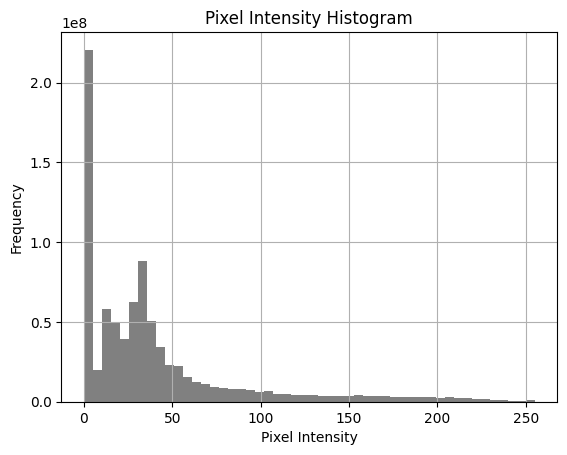

In [16]:
plot_intensity_histogram(X)

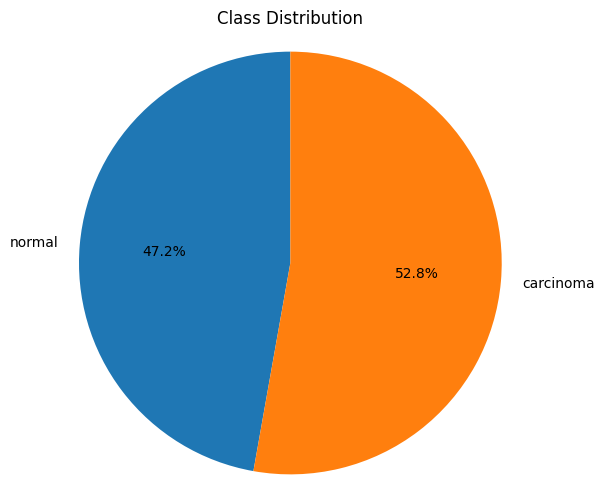

In [19]:
unique_labels, class_counts = np.unique(y, return_counts=True)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels={'normal','carcinoma'}, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

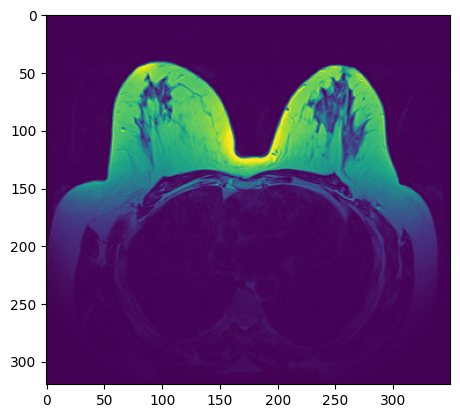

In [20]:
plt.imshow(X[0])

## Preprocessing Pipeline

This section prepares the CT scan images for machine learning. We apply a consistent set of transformations to all images, including:

- Conversion to grayscale numpy arrays (already handled during loading)
- Normalization of pixel values to [0, 1]
- Resizing images to 224x224
- Optional handling of class imbalance (oversampling)

These steps ensure the input data is consistent in format and scale, which improves model training.


## Data Splitting

We split the data into Train, Validation, and Test sets in a 80:10:10 ratio.

Key Considerations:
- Ensured balanced class representation across all splits.
- No patient overlap (if patient IDs are available – here, we assume file-level uniqueness).


## **🧠 Functional Preprocessing Code**


In [24]:
def normalize_image(img, to_range=(0, 1)):
    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    norm_img = (img - min_val) / (max_val - min_val + 1e-8)
    if to_range == (-1, 1):
        norm_img = norm_img * 2 - 1
    return norm_img

def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def preprocess_image(img, size=(224, 224), to_range=(0, 1)):
    return normalize_image(resize_image(img, size), to_range)

def apply_preprocessing(X, size=(224, 224), to_range=(0, 1)):
    return list(map(partial(preprocess_image, size=size, to_range=to_range), tqdm(X, desc="Preprocessing images")))

def split_data(X, y, train_size=0.8, val_size=0.1, test_size=0.1):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    val_ratio = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [25]:
X_processed = apply_preprocessing(X, size=(224, 224), to_range=(0, 1))

Preprocessing images: 100%|██████████| 2807/2807 [00:02<00:00, 939.23it/s] 


In [26]:
(train_X, train_y), (val_X, val_y), (test_X, test_y) = split_data(X_processed, y)
print(f"Train: {len(train_X)}, Val: {len(val_X)}, Test: {len(test_X)}")

Train: 2245, Val: 281, Test: 281


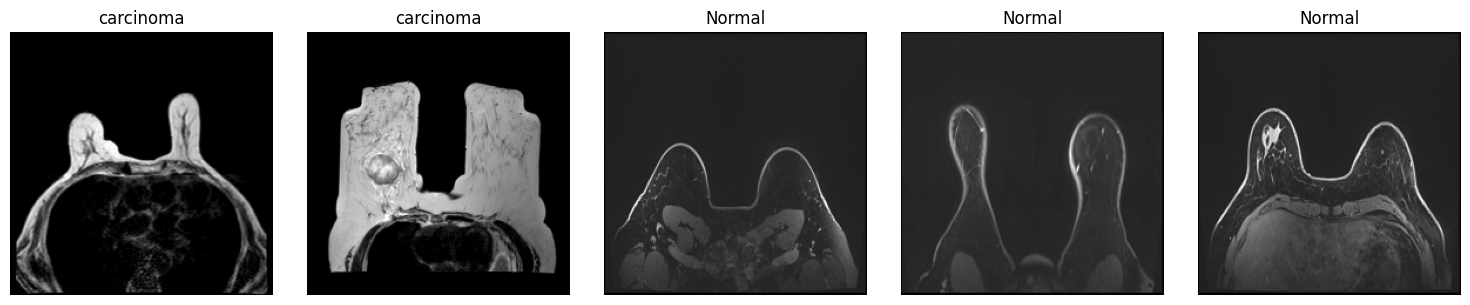

In [27]:
visualize_samples(train_X, train_y)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# --- Custom Dataset Class ---
class CustomDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = np.expand_dims(X, axis=1).astype(np.float32)  # (N, 1, H, W)
        self.y = np.array(y).astype(np.float32)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        # Apply augmentations if needed
        return torch.tensor(x), torch.tensor(y)


def to_torch_dataloader(X, y, batch_size=32, shuffle=True, augment=False):
    dataset = CustomDataset(X, y, augment=augment)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [30]:
# --- Model Definition ---
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


# --- Training Setup ---
def get_loss():
    return nn.BCELoss()

def get_optimizer(model, lr=1e-4):
    return torch.optim.Adam(model.parameters(), lr=lr)


# --- Plotting Training History ---
def plot_training_history(history, metrics=('loss', 'accuracy', 'auc')):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(5 * len(metrics), 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(epochs, history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history:
            plt.plot(epochs, history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [47]:
train_ds = to_torch_dataloader(train_X, train_y)
val_ds = to_torch_dataloader(val_X, val_y, shuffle=False)
test_ds = to_torch_dataloader(test_X, test_y, shuffle=False)

baseline_model = BaselineCNN()
optimizer = get_optimizer(baseline_model)
criterion = get_loss()

history = {'loss': [], 'accuracy': [], 'auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model.to(device)

BaselineCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [48]:
for epoch in range(50):
    baseline_model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true_train, y_pred_train = [], []
    for inputs, labels in train_ds:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    train_loss = running_loss / total
    train_acc = correct / total
    train_auc = f1_score(y_true_train, y_pred_train)

    baseline_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for inputs, labels in val_ds:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = baseline_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_auc = f1_score(y_true_val, y_pred_val)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1}/50 | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")



Epoch 1/50 | Train Loss: 0.6674, Acc: 0.5791, AUC: 0.6968 | Val Loss: 0.5922, Acc: 0.7082, AUC: 0.7819
Epoch 2/50 | Train Loss: 0.5157, Acc: 0.8022, AUC: 0.8249 | Val Loss: 0.4702, Acc: 0.8399, AUC: 0.8571
Epoch 3/50 | Train Loss: 0.4687, Acc: 0.8031, AUC: 0.8202 | Val Loss: 0.4374, Acc: 0.8149, AUC: 0.8312
Epoch 4/50 | Train Loss: 0.4555, Acc: 0.7978, AUC: 0.8142 | Val Loss: 0.4202, Acc: 0.8114, AUC: 0.8274
Epoch 5/50 | Train Loss: 0.4336, Acc: 0.8053, AUC: 0.8221 | Val Loss: 0.3995, Acc: 0.8221, AUC: 0.8387
Epoch 6/50 | Train Loss: 0.4241, Acc: 0.8036, AUC: 0.8189 | Val Loss: 0.3829, Acc: 0.8185, AUC: 0.8339
Epoch 7/50 | Train Loss: 0.3957, Acc: 0.8102, AUC: 0.8267 | Val Loss: 0.3646, Acc: 0.8149, AUC: 0.8301
Epoch 8/50 | Train Loss: 0.3842, Acc: 0.8067, AUC: 0.8221 | Val Loss: 0.3672, Acc: 0.8399, AUC: 0.8571
Epoch 9/50 | Train Loss: 0.3723, Acc: 0.8156, AUC: 0.8291 | Val Loss: 0.3394, Acc: 0.8327, AUC: 0.8479
Epoch 10/50 | Train Loss: 0.3529, Acc: 0.8209, AUC: 0.8336 | Val Loss: 0.

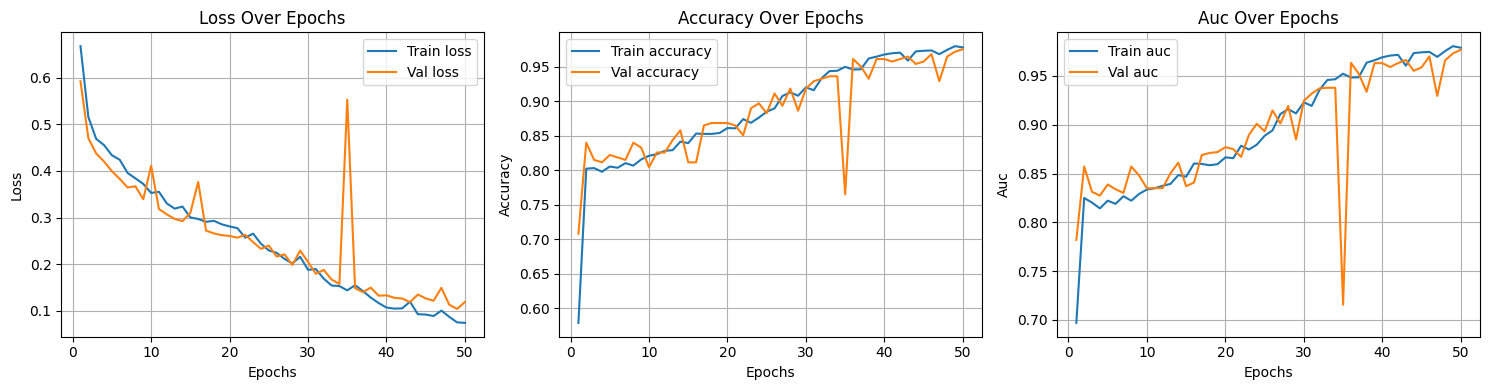

In [49]:
plot_training_history(history, metrics=('loss', 'accuracy', 'auc'))

In [51]:
for epoch in range(5):
    baseline_model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true_train, y_pred_train = [], []
    for inputs, labels in train_ds:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    train_loss = running_loss / total
    train_acc = correct / total
    train_auc = f1_score(y_true_train, y_pred_train)

    baseline_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for inputs, labels in val_ds:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = baseline_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_auc = f1_score(y_true_val, y_pred_val)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1}/40 | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

####################################50 epoch#####################

Epoch 1/40 | Train Loss: 0.0838, Acc: 0.9768, AUC: 0.9781 | Val Loss: 0.1856, Acc: 0.9609, AUC: 0.9642
Epoch 2/40 | Train Loss: 0.1012, Acc: 0.9639, AUC: 0.9658 | Val Loss: 0.1015, Acc: 0.9715, AUC: 0.9733
Epoch 3/40 | Train Loss: 0.0773, Acc: 0.9791, AUC: 0.9802 | Val Loss: 0.1083, Acc: 0.9609, AUC: 0.9625
Epoch 4/40 | Train Loss: 0.0672, Acc: 0.9826, AUC: 0.9836 | Val Loss: 0.1008, Acc: 0.9644, AUC: 0.9660
Epoch 5/40 | Train Loss: 0.0734, Acc: 0.9795, AUC: 0.9806 | Val Loss: 0.1073, Acc: 0.9715, AUC: 0.9735


In [54]:
baseline_model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for inputs, labels in test_ds:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

test_loss /= test_total
test_accuracy = test_correct / test_total
test_auc = f1_score(y_true_test, y_pred_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

Test Loss: 0.07996262016033363
Test Accuracy: 0.9822064056939501
Test AUC: 0.972972972972973


In [44]:
# --- Save the model ---
torch.save(baseline_model.state_dict(), 'Breast_Cancer.pth')

In [45]:
def visualize_predictions(model, dataloader, num_samples=20):
    model.eval()
    data_iter = iter(dataloader)
    plt.figure(figsize=(20, 4))
    shown = 0

    with torch.no_grad():
        while shown < num_samples:
            inputs, labels = next(data_iter)
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            inputs = inputs.cpu().numpy()
            labels = labels.numpy()

            for i in range(len(inputs)):
                if shown >= num_samples:
                    break
                plt.subplot(2, 10, shown + 1)
                img = inputs[i][0]  # grayscale
                true_label = labels[i]
                pred_label = preds[i]
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                title = f"True: {'Breast_Cancer' if true_label == 1 else 'Normal'}\nPred: {'Breast_Cancer' if pred_label > 0.5 else 'Normal'}"
                plt.title(title, fontsize=10)
                shown += 1
    plt.tight_layout()
    plt.show()

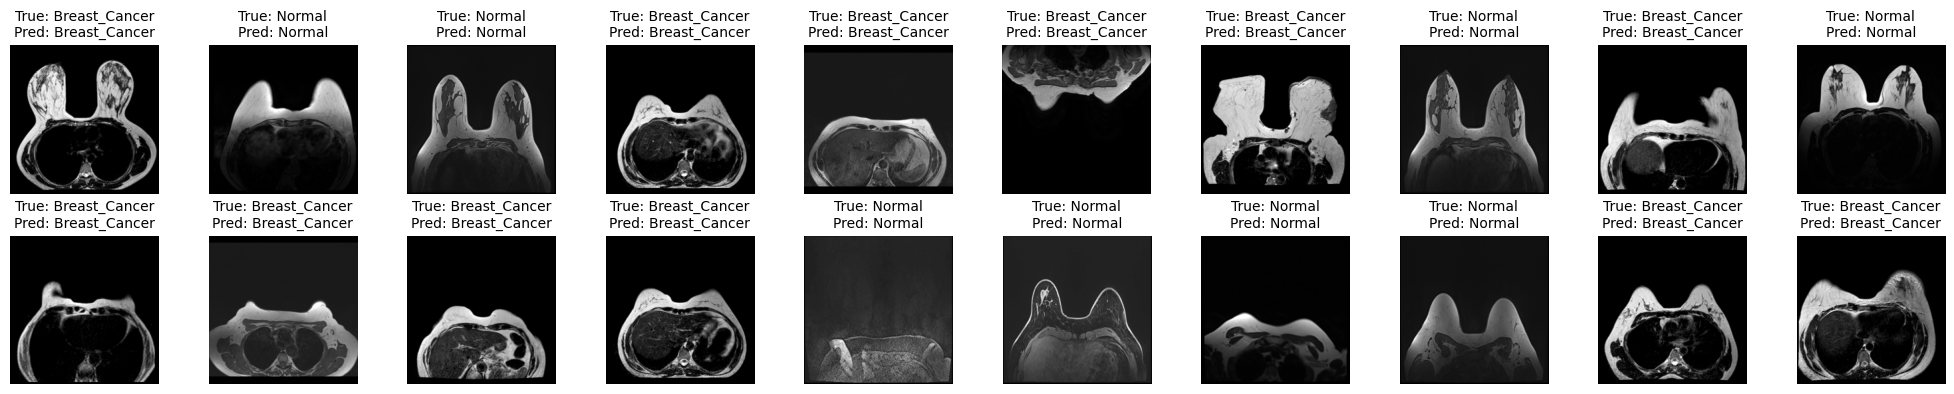

In [46]:
visualize_predictions(baseline_model, test_ds, num_samples=20)